In [1]:
LOCAL = False
import os
import importlib

if LOCAL:
    path = '/Users/berk/Documents/research/nna/src/scripts/'
else:
    path = '/home/enis/projects/nna/src/scripts/'
os.chdir(path)

import teacher
from nna import weather

# import itertools
import pandas as pd

import numpy as np
import random


Output(layout=Layout(border='1px solid black'))

In [5]:
importlib.reload(teacher)
importlib.reload(weather)

version_tag = 'weather_V5'
dataset_version = 'W5'

FILE_PER_LOCATION = 30000
TIMESTAMPS_PER_ROW = 4

config = teacher.setup(versiontag=version_tag)

if LOCAL:
    weather_data_folder = '/Users/berk/Downloads/NNA_files/weather_data/2017_2020'
else:
    weather_data_folder = '/scratch/enis/data/nna/weather_data/2017_2020'

root_path = '/scratch/enis/data/nna/labeling/samples'
config['split_out_path'] = f'{root_path}/{version_tag}/audio_'

## data-1: as many sampes as possible
config['new_dataset_path'] = f'{root_path}/{version_tag}/{version_tag}.csv'
config['dataset_version'] = dataset_version
# config['versiontag'] = 'yfitloiq-V1'
config['excell_label_headers'] = [
    'day_length', 'air_temp', 'snow_depth', 'cloud_fraction',
    'relative_humidity', 'runoff', 'rain_precip', 'snow_precip',
    'wind_direction', 'wind_speed'
]

# config['excell_label_headers']=['day_length','air_temp','snow_depth',
#         'cloud_fraction','relative_humidity','runoff','rain_precip',
#          'snow_precip','wind_direction','wind_speed',
#         'snow_blowing_ground','snow_blowing_air',]

config['upper_taxo_links'] = {}

# print('total sample count to be produced:',file_per_location*len(short_ones.keys()))

# 40 Prudhoe or ANWR monitoring sites AND the Ivvavik sites
short_input_csv_headers = [
    'day_length', 'air_temp', 'snow_depth', 'cloud_fraction',
    'relative_humidity', 'runoff', 'rain_precip', 'snow_precip',
    'wind_direction', 'wind_speed'
]
# (year,month,day,hour,day_length,air_temp,snow_depth,
#                 cloud_fraction,relative_humidity,runoff,rain_precip,
#                     snow_precip,wind_direction,wind_speed)=row
# for Dalton and Dempster
long_input_csv_headers = [
    'day_length', 'air_temp', 'snow_depth', 'cloud_fraction',
    'relative_humidity', 'runoff', 'rain_precip', 'snow_precip', 'total_precip',
    'wind_direction', 'wind_speed', 'snow_blowing_ground', 'snow_blowing_air'
]

excell_all_headers = [
    'data_version', 'Annotator', 'Site ID', 'File Name', 'Date', 'Start Time',
    'End Time', 'Length', 'Clip Path', 'Comments', 'weather_timestamp',
    'region', 'day_length', 'air_temp', 'snow_depth', 'cloud_fraction',
    'relative_humidity', 'runoff', 'rain_precip', 'rain_precip_mm',
    'snow_precip', 'wind_direction', 'wind_speed'
]

# (year,month,day,hour,day_length,air_temp,snow_depth,
# cloud_fraction,relative_humidity,runoff,rain_precip,
# snow_precip,total_precip,wind_direction,wind_speed,
# snow_blowing_ground,snow_blowing_air)=row

short_locations = ('prudhoe', 'ivvavik', 'anwr')
long_locations = ('dalton', 'dempster')

if LOCAL:
    file_database = '/Users/berk/Documents/scratch/enis/data/nna/database/allFields_dataV10.pkl'
else:
    file_database = '/scratch/enis/data/nna/database/allFields_dataV10.pkl'

neon_weather_data_path = '/scratch/enis/data/nna/weather_data/NEON_precipitation/'
NEON_LENGTH_MIN = 5


In [10]:
def generate_new_dataset4weather_rows_v2(region, location, file_properties_df,
                                         weather_data, file_per_location):

    filtered_files = file_properties_df[file_properties_df['region'] == region]
    filtered_files = filtered_files[filtered_files['locationId'] == location]

    # weather_data = weather.load_weather_data(region, location, fname, short_locations,
    #                                  long_locations, short_input_csv_headers,
    #                                  long_input_csv_headers)

    # Find the earliest start and end timestamps in weather_data
    earliest_start = weather_data['TIMESTAMP'].min()
    earliest_end = weather_data['TIMESTAMP'].max()

    # Filter the rows of filtered_files dataframe
    filtered_files = filtered_files[
        (filtered_files['timestamp'] >= earliest_start) &
        (filtered_files['timestampEnd'] <= earliest_end)]

    # Check if filtered_files is empty
    if filtered_files.empty:
        print('No matching files found!')
    else:
        weather_rows = weather.get_weather_rows(filtered_files,
                                                weather_data,
                                                file_per_location,
                                                weather_data_freq=60 *
                                                NEON_LENGTH_MIN)
        buffer_seconds = 0

        new_dataset_csv, not_found_rows = teacher.generate_new_dataset(
            weather_rows,
            config['versiontag'],
            config['split_out_path'],
            file_properties_df,
            config['upper_taxo_links'],
            config['dataset_version'],
            buffer=buffer_seconds,
            excell_label_headers={},  #config['excell_label_headers'],
            labels_thresholds={},  #config['labels_thresholds'],
            outputSuffix='.wav',
            dry_run=False,
            excell_labels_2_names={},  #config['excell_labels_2_names'],
            stereo2mono=True,
            overwrite=True,
            sampling_rate=48000,
            label_row_by_threshold=False,
            print_logs=False,
        )
        return new_dataset_csv, not_found_rows, weather_rows

    return [], [], pd.DataFrame()

In [19]:
import re
from datetime import datetime, timedelta
from pathlib import Path
import glob
import pandas as pd
from nna import weather


def parse_duration(duration_str):
    minutes, seconds = map(int, duration_str[:-1].split("m_"))
    return timedelta(minutes=minutes, seconds=seconds)


def parse_excerpt_name(excerpt_name):
    # Regular expression to match the required pattern
    pattern = r"(?P<orig_filename>S4A\d{5}_\d{8}_\d{6})_(?P<start_excerpt>\d+m_\d+s)__(?P<end_excerpt>\d+m_\d+s)\.wav"

    # Search for the pattern in the given excerpt_name
    match = re.search(pattern, excerpt_name)

    if match:
        orig_filename = match.group("orig_filename")
        date = orig_filename.split("_")[1]
        time = orig_filename.split("_")[2]
        start_excerpt = match.group("start_excerpt")
        end_excerpt = match.group("end_excerpt")
        date_time_obj = datetime.strptime(date + time, "%Y%m%d%H%M%S")
    else:
        print("Filename doesn't match the expected pattern.")
        return None

    return orig_filename, date, time, start_excerpt, end_excerpt, date_time_obj


def get_original_file_path(parent_path, region, location, orig_filename, year):
    # Find the original file
    orig_file_path = f'{parent_path}/{region}/{location}/{year}/{orig_filename}.flac'
    orig_file_path = Path(orig_file_path)
    return orig_file_path


def get_orig_row(orig_file_path, file_properties_df):
    # Find the row in file_properties_df that corresponds to the original file
    # by index (file path)
    orig_row = file_properties_df.loc[orig_file_path]
    return orig_row


def get_orig_row_from_excerpt_name(excerpt_name, region, location, parent_path,
                                   file_properties_df):
    orig_filename, date, time, start_excerpt, end_excerpt, date_time_obj = parse_excerpt_name(
        excerpt_name)  # type: ignore
    orig_file_path = get_original_file_path(parent_path, region, location,
                                            orig_filename, date_time_obj.year)
    orig_row = get_orig_row(orig_file_path, file_properties_df)
    return orig_row, start_excerpt, end_excerpt, date_time_obj


NEON_LENGTH_MIN = 5


def match_datasset(region, location, neon_weather_data_path, file_properties_df,
                   dataset_df_made):

    filtered_files = file_properties_df[file_properties_df['region'] == region]
    filtered_files = filtered_files[filtered_files['locationId'] == location]

    weather_data = weather.load_neon_data(neon_weather_data_path,
                                          length=NEON_LENGTH_MIN,
                                          region=region,
                                          location=location)

    # weather_data = weather.load_weather_data(region, location, fname,
    #                                          short_locations, long_locations,
    #                                          short_input_csv_headers,
    #                                          long_input_csv_headers)

    # Find the earliest start and end timestamps in weather_data
    earliest_start = weather_data['TIMESTAMP'].min()
    earliest_end = weather_data['TIMESTAMP'].max()

    # Filter the rows of filtered_files dataframe
    filtered_files = filtered_files[
        (filtered_files['timestamp'] >= earliest_start) &
        (filtered_files['timestampEnd'] <= earliest_end)]

    interval_index = weather.get_weather_index(weather_data)
    valid_indices = []
    valid_timestamps = []
    # Check if filtered_files is empty
    if filtered_files.empty:
        print('No matching files found!')
    else:
        for random_timestamp in dataset_df_made['TIMESTAMP'].values:

            weather_bind_index = weather.get_bin_index(interval_index,
                                                       random_timestamp)
            if weather_bind_index != -1:
                valid_indices.append(weather_bind_index)
                valid_timestamps.append(random_timestamp)
            else:
                print('No matching weather data found for', random_timestamp)
    print(weather_rows)
    print(valid_indices)
    weather_rows = weather_data.iloc[valid_indices].copy()
    weather_rows.loc[:, 'timestamp_orig_weather'] = weather_rows['TIMESTAMP']
    weather_rows.loc[:, 'TIMESTAMP'] = valid_timestamps
    return weather_rows


In [8]:
file_properties_df = pd.read_pickle(file_database)
station_csv = weather.csv_path_per_regloc(weather_data_folder)
station_years = weather.year_per_regloc(station_csv, file_properties_df)


In [9]:
location = '09'
region = 'dalton'
experts_folder = '/scratch/enis/data/nna/labeling/samples/weather_V4/audio_weather_V4/dalton/09/'
version_tag = 'weather_V4'
dataset_version = 'W4'

all_excperts = glob.glob(f'{experts_folder}/*.wav')
rows = []
for excerpt_name in all_excperts:
    excerpt_name = excerpt_name.split('/')[-1]
    orig_row, start_excerpt, end_excerpt, date_time_obj = get_orig_row_from_excerpt_name(
        excerpt_name, region, location, '/tank/data/nna/real/',
        file_properties_df)
    start_excerpt = parse_duration(start_excerpt)
    end_excerpt = parse_duration(end_excerpt)

    start_excerpt_time_obj = date_time_obj + start_excerpt
    end_excerpt_time_obj = date_time_obj + end_excerpt
    # print(start_excerpt_time_obj, end_excerpt_time_obj)

    row_dict = teacher.generate_new_row(dataset_version, version_tag, location,
                                        orig_row.name, 10,
                                        start_excerpt_time_obj)
    row_dict['Clip Path'] = Path(experts_folder) / excerpt_name
    row_dict['Comments'] = ''
    rows.append(row_dict)

dataset_df_made = pd.DataFrame(rows)

dataset_df_made['TIMESTAMP'] = pd.to_datetime(dataset_df_made['Date'] + ' ' +
                                              dataset_df_made['Start Time'])


In [20]:
dataset_df_made

,data_version,Annotator,Site ID,File Name,Start Time,End Time,Date,Length,Clip Path,Comments,TIMESTAMP
0,W4,weather_V4,09,/tank/data/nna/real/dalton/09/2019/S4A10422_20...,10:50:38.000000,10:50:48.000000,03/24/2019,00:00:10.000000,/scratch/enis/data/nna/labeling/samples/weathe...,,2019-03-24 10:50:38
1,W4,weather_V4,09,/tank/data/nna/real/dalton/09/2019/S4A10422_20...,09:31:03.000000,09:31:13.000000,05/03/2019,00:00:10.000000,/scratch/enis/data/nna/labeling/samples/weathe...,,2019-05-03 09:31:03
2,W4,weather_V4,09,/tank/data/nna/real/dalton/09/2019/S4A10422_20...,14:50:41.000000,14:50:51.000000,05/07/2019,00:00:10.000000,/scratch/enis/data/nna/labeling/samples/weathe...,,2019-05-07 14:50:41
3,W4,weather_V4,09,/tank/data/nna/real/dalton/09/2019/S4A10422_20...,21:22:59.000000,21:23:09.000000,08/29/2019,00:00:10.000000,/scratch/enis/data/nna/labeling/samples/weathe...,,2019-08-29 21:22:59
4,W4,weather_V4,09,/tank/data/nna/real/dalton/09/2019/S4A10422_20...,16:01:57.000000,16:02:07.000000,10/10/2019,00:00:10.000000,/scratch/enis/data/nna/labeling/samples/weathe...,,2019-10-10 16:01:57
...,...,...,...,...,...,...,...,...,...,...,...
29397,W4,weather_V4,09,/tank/data/nna/real/dalton/09/2019/S4A10422_20...,16:03:23.000000,16:03:33.000000,09/13/2019,00:00:10.000000,/scratch/enis/data/nna/labeling/samples/weathe...,,2019-09-13 16:03:23
29398,W4,weather_V4,09,/tank/data/nna/real/dalton/09/2019/S4A10422_20...,01:31:12.000000,01:31:22.000000,04/19/2019,00:00:10.000000,/scratch/enis/data/nna/labeling/samples/weathe...,,2019-04-19 01:31:12
29399,W4,weather_V4,09,/tank/data/nna/real/dalton/09/2019/S4A10422_20...,18:53:59.000000,18:54:09.000000,04/30/2019,00:00:10.000000,/scratch/enis/data/nna/labeling/samples/weathe...,,2019-04-30 18:53:59
29400,W4,weather_V4,09,/tank/data/nna/real/dalton/09/2019/S4A10422_20...,09:31:36.000000,09:31:46.000000,04/13/2019,00:00:10.000000,/scratch/enis/data/nna/labeling/samples/weathe...,,2019-04-13 09:31:36


In [21]:
# fname = station_csv[(region, location)]
# weather_rows = match_datasset(region, location, file_properties_df, fname,
#                                 short_locations, long_locations,
#                                 short_input_csv_headers,
#                                 long_input_csv_headers, dataset_df_made)

weather_rows = match_datasset(region, location, neon_weather_data_path,
                              file_properties_df, dataset_df_made)


UnboundLocalError: local variable 'weather_rows' referenced before assignment

In [39]:
filtered_files = file_properties_df[file_properties_df['region'] == region]
filtered_files = filtered_files[filtered_files['locationId'] == location]

weather_data = weather.load_neon_data(neon_weather_data_path,
                                      length=NEON_LENGTH_MIN,
                                      region=region,
                                      location=location)

# weather_data = weather.load_weather_data(region, location, fname,
#                                          short_locations, long_locations,
#                                          short_input_csv_headers,
#                                          long_input_csv_headers)

# Find the earliest start and end timestamps in weather_data
earliest_start = weather_data['TIMESTAMP'].min()
earliest_end = weather_data['TIMESTAMP'].max()

# Filter the rows of filtered_files dataframe
filtered_files = filtered_files[
    (filtered_files['timestamp'] >= earliest_start) &
    (filtered_files['timestampEnd'] <= earliest_end)]

interval_index = weather.get_weather_index(weather_data,
                                           weather_data_freq=NEON_LENGTH_MIN *
                                           60)
valid_indices = []
valid_timestamps = []
# Check if filtered_files is empty
if filtered_files.empty:
    print('No matching files found!')
else:
    for random_timestamp in dataset_df_made['TIMESTAMP'].values:

        weather_bind_index = weather.get_bin_index(interval_index,
                                                   random_timestamp)
        if weather_bind_index != -1:
            valid_indices.append(weather_bind_index)
            valid_timestamps.append(random_timestamp)
        else:
            print('No matching weather data found for', random_timestamp)
print(valid_indices)
integer_indices = [
    index for s in valid_indices
    for index in range(s.start, s.stop, s.step or 1)
]
weather_rows = weather_data.iloc[integer_indices].copy()
weather_rows.loc[:, 'timestamp_orig_weather'] = weather_rows['TIMESTAMP']
weather_rows.loc[:, 'TIMESTAMP'] = valid_timestamps


[128962, 140466, 141682, 174592, 186624, 134386, 147794, 150322, 188608, 136673, 176960, 136018, 132882, 128770, 181200, 142402, 171504, 170672, 167066, 143378, 136002, 127858, 172288, 147074, 153240, 187424, 132178, 186304, 186064, 147202, 142786, 184720, 130370, 139554, 148514, 136450, 176496, 177312, 140642, 141794, 142770, 176448, 138610, 128930, 152016, 178048, 181312, 175488, 130930, 129906, 153098, 189072, 173200, 137873, 183232, 139026, 128210, 155256, 188800, 141074, 129330, 142401, 142866, 129442, 179712, 187280, 137202, 169568, 187968, 127634, 174688, 138146, 133425, 185984, 182640, 134850, 149858, 147425, 129410, 190352, 144994, 132802, 169520, 176608, 187632, 185312, 189200, 128609, 138514, 146738, 151801, 133762, 175216, 129474, 156409, 180560, 159288, 169472, 188032, 165192, 177936, 150402, 133233, 180960, 182912, 169168, 132370, 150449, 137298, 170112, 171776, 186480, 153384, 179984, 184640, 180768, 178608, 130226, 189264, 146242, 134402, 180672, 179072, 129538, 182752,

In [33]:
integer_indices = [
    index for s in valid_indices
    for index in range(s.start, s.stop, s.step or 1)
]
weather_rows = weather_data.iloc[integer_indices].copy()
weather_rows.loc[:, 'timestamp_orig_weather'] = weather_rows['TIMESTAMP']
weather_rows.loc[:, 'TIMESTAMP'] = valid_timestamps


In [40]:
weather_rows.shape

(29402, 11)

In [60]:
dataset = pd.merge(weather_rows, dataset_df_made, on=['TIMESTAMP'], how='inner')
dataset['rain_precip_mm'] = dataset['priPrecipBulk']
dataset['weather_timestamp'] = dataset['startDateTime']


In [58]:
dataset

,startDateTime,endDateTime,priPrecipBulk,priPrecipExpUncert,priPrecipFinalQF,location,region,TIMESTAMP,timestamp_start,timestamp_end,...,Annotator,Site ID,File Name,Start Time,End Time,Date,Length,Clip Path,Comments,rain_precip_mm
0,2019-03-24 10:50:00,2019-03-24 10:55:00,0.02,0.001,0,09,dalton,2019-03-24 10:50:38,2019-03-24 10:50:00,2019-03-24 10:55:00,...,weather_V4,09,/tank/data/nna/real/dalton/09/2019/S4A10422_20...,10:50:38.000000,10:50:48.000000,03/24/2019,00:00:10.000000,/scratch/enis/data/nna/labeling/samples/weathe...,,0.02
1,2019-05-03 09:30:00,2019-05-03 09:35:00,0.00,0.000,0,09,dalton,2019-05-03 09:31:03,2019-05-03 09:30:00,2019-05-03 09:35:00,...,weather_V4,09,/tank/data/nna/real/dalton/09/2019/S4A10422_20...,09:31:03.000000,09:31:13.000000,05/03/2019,00:00:10.000000,/scratch/enis/data/nna/labeling/samples/weathe...,,0.00
2,2019-05-07 14:50:00,2019-05-07 14:55:00,0.00,0.000,0,09,dalton,2019-05-07 14:50:41,2019-05-07 14:50:00,2019-05-07 14:55:00,...,weather_V4,09,/tank/data/nna/real/dalton/09/2019/S4A10422_20...,14:50:41.000000,14:50:51.000000,05/07/2019,00:00:10.000000,/scratch/enis/data/nna/labeling/samples/weathe...,,0.00
3,2019-08-29 21:20:00,2019-08-29 21:25:00,0.00,0.000,0,09,dalton,2019-08-29 21:22:59,2019-08-29 21:20:00,2019-08-29 21:25:00,...,weather_V4,09,/tank/data/nna/real/dalton/09/2019/S4A10422_20...,21:22:59.000000,21:23:09.000000,08/29/2019,00:00:10.000000,/scratch/enis/data/nna/labeling/samples/weathe...,,0.00
4,2019-10-10 16:00:00,2019-10-10 16:05:00,0.00,0.000,0,09,dalton,2019-10-10 16:01:57,2019-10-10 16:00:00,2019-10-10 16:05:00,...,weather_V4,09,/tank/data/nna/real/dalton/09/2019/S4A10422_20...,16:01:57.000000,16:02:07.000000,10/10/2019,00:00:10.000000,/scratch/enis/data/nna/labeling/samples/weathe...,,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29397,2019-09-13 16:00:00,2019-09-13 16:05:00,0.00,0.000,0,09,dalton,2019-09-13 16:03:23,2019-09-13 16:00:00,2019-09-13 16:05:00,...,weather_V4,09,/tank/data/nna/real/dalton/09/2019/S4A10422_20...,16:03:23.000000,16:03:33.000000,09/13/2019,00:00:10.000000,/scratch/enis/data/nna/labeling/samples/weathe...,,0.00
29398,2019-04-19 01:30:00,2019-04-19 01:35:00,0.00,0.000,0,09,dalton,2019-04-19 01:31:12,2019-04-19 01:30:00,2019-04-19 01:35:00,...,weather_V4,09,/tank/data/nna/real/dalton/09/2019/S4A10422_20...,01:31:12.000000,01:31:22.000000,04/19/2019,00:00:10.000000,/scratch/enis/data/nna/labeling/samples/weathe...,,0.00
29399,2019-04-30 18:50:00,2019-04-30 18:55:00,0.00,0.000,0,09,dalton,2019-04-30 18:53:59,2019-04-30 18:50:00,2019-04-30 18:55:00,...,weather_V4,09,/tank/data/nna/real/dalton/09/2019/S4A10422_20...,18:53:59.000000,18:54:09.000000,04/30/2019,00:00:10.000000,/scratch/enis/data/nna/labeling/samples/weathe...,,0.00
29400,2019-04-13 09:30:00,2019-04-13 09:35:00,0.00,0.000,0,09,dalton,2019-04-13 09:31:36,2019-04-13 09:30:00,2019-04-13 09:35:00,...,weather_V4,09,/tank/data/nna/real/dalton/09/2019/S4A10422_20...,09:31:36.000000,09:31:46.000000,04/13/2019,00:00:10.000000,/scratch/enis/data/nna/labeling/samples/weathe...,,0.00


In [66]:
dataset.columns

Index(['startDateTime', 'endDateTime', 'priPrecipBulk', 'priPrecipExpUncert',
       'priPrecipFinalQF', 'location', 'region', 'TIMESTAMP',
       'timestamp_start', 'timestamp_end', 'timestamp_orig_weather',
       'data_version', 'Annotator', 'Site ID', 'File Name', 'Start Time',
       'End Time', 'Date', 'Length', 'Clip Path', 'Comments', 'rain_precip_mm',
       'weather_timestamp'],
      dtype='object')

,data_version,Annotator,Site ID,File Name,Date,Start Time,End Time,Length,Clip Path,Comments,weather_timestamp,region,priPrecipBulk,priPrecipExpUncert,priPrecipFinalQF
0,W4,weather_V4,09,/tank/data/nna/real/dalton/09/2019/S4A10422_20...,03/24/2019,10:50:38.000000,10:50:48.000000,00:00:10.000000,/scratch/enis/data/nna/labeling/samples/weathe...,,2019-03-24 10:50:00,dalton,0.02,0.001,0
1,W4,weather_V4,09,/tank/data/nna/real/dalton/09/2019/S4A10422_20...,05/03/2019,09:31:03.000000,09:31:13.000000,00:00:10.000000,/scratch/enis/data/nna/labeling/samples/weathe...,,2019-05-03 09:30:00,dalton,0.00,0.000,0
2,W4,weather_V4,09,/tank/data/nna/real/dalton/09/2019/S4A10422_20...,05/07/2019,14:50:41.000000,14:50:51.000000,00:00:10.000000,/scratch/enis/data/nna/labeling/samples/weathe...,,2019-05-07 14:50:00,dalton,0.00,0.000,0
3,W4,weather_V4,09,/tank/data/nna/real/dalton/09/2019/S4A10422_20...,08/29/2019,21:22:59.000000,21:23:09.000000,00:00:10.000000,/scratch/enis/data/nna/labeling/samples/weathe...,,2019-08-29 21:20:00,dalton,0.00,0.000,0
4,W4,weather_V4,09,/tank/data/nna/real/dalton/09/2019/S4A10422_20...,10/10/2019,16:01:57.000000,16:02:07.000000,00:00:10.000000,/scratch/enis/data/nna/labeling/samples/weathe...,,2019-10-10 16:00:00,dalton,0.00,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29397,W4,weather_V4,09,/tank/data/nna/real/dalton/09/2019/S4A10422_20...,09/13/2019,16:03:23.000000,16:03:33.000000,00:00:10.000000,/scratch/enis/data/nna/labeling/samples/weathe...,,2019-09-13 16:00:00,dalton,0.00,0.000,0
29398,W4,weather_V4,09,/tank/data/nna/real/dalton/09/2019/S4A10422_20...,04/19/2019,01:31:12.000000,01:31:22.000000,00:00:10.000000,/scratch/enis/data/nna/labeling/samples/weathe...,,2019-04-19 01:30:00,dalton,0.00,0.000,0
29399,W4,weather_V4,09,/tank/data/nna/real/dalton/09/2019/S4A10422_20...,04/30/2019,18:53:59.000000,18:54:09.000000,00:00:10.000000,/scratch/enis/data/nna/labeling/samples/weathe...,,2019-04-30 18:50:00,dalton,0.00,0.000,0
29400,W4,weather_V4,09,/tank/data/nna/real/dalton/09/2019/S4A10422_20...,04/13/2019,09:31:36.000000,09:31:46.000000,00:00:10.000000,/scratch/enis/data/nna/labeling/samples/weathe...,,2019-04-13 09:30:00,dalton,0.00,0.000,0


In [9]:
# file_properties_df=file_properties_df[(file_properties_df['region']=='dalton') & (file_properties_df['locationId']=='09')].copy()
# file_properties_df=file_properties_df[].copy()


In [68]:
config['new_dataset_path']

'/scratch/enis/data/nna/labeling/samples/weather_V5/weather_V5.csv'

In [69]:
assert dataset['Clip Path'].unique(
).shape[0] == dataset.shape[0], 'Clip Path is not unique'
# dataset['weather_timestamp']=dataset['timestamp_orig_weather']
dataset[excell_all_headers[:12] + [
    'priPrecipBulk',
    'priPrecipExpUncert',
    'priPrecipFinalQF',
]].to_csv(
    '/scratch/enis/data/nna/labeling/samples/weather_V4/weather_V4_neon.csv',
    index=False,
    header=True,
)


In [135]:
dataset['Clip Path'].unique().shape[0], dataset.shape[0]


(29402, 29402)

In [12]:
# dataset=dataset.drop_duplicates(subset=['Clip Path'])

In [71]:
dataset[['rain_precip_mm']]

,rain_precip_mm
0,0.02
1,0.00
2,0.00
3,0.00
4,0.00
...,...
29397,0.00
29398,0.00
29399,0.00
29400,0.00


In [75]:
dataset[dataset['rain_precip_mm'] > 0.027]


,startDateTime,endDateTime,priPrecipBulk,priPrecipExpUncert,priPrecipFinalQF,location,region,TIMESTAMP,timestamp_start,timestamp_end,...,Site ID,File Name,Start Time,End Time,Date,Length,Clip Path,Comments,rain_precip_mm,weather_timestamp
6,2019-05-28 20:10:00,2019-05-28 20:15:00,0.05,0.002,0,09,dalton,2019-05-28 20:10:37,2019-05-28 20:10:00,2019-05-28 20:15:00,...,09,/tank/data/nna/real/dalton/09/2019/S4A10422_20...,20:10:37.000000,20:10:47.000000,05/28/2019,00:00:10.000000,/scratch/enis/data/nna/labeling/samples/weathe...,,0.05,2019-05-28 20:10:00
15,2019-05-10 02:50:00,2019-05-10 02:55:00,0.05,0.002,1,09,dalton,2019-05-10 02:53:45,2019-05-10 02:50:00,2019-05-10 02:55:00,...,09,/tank/data/nna/real/dalton/09/2019/S4A10422_20...,02:53:45.000000,02:53:55.000000,05/10/2019,00:00:10.000000,/scratch/enis/data/nna/labeling/samples/weathe...,,0.05,2019-05-10 02:50:00
19,2019-05-13 12:10:00,2019-05-13 12:15:00,0.03,0.001,0,09,dalton,2019-05-13 12:12:51,2019-05-13 12:10:00,2019-05-13 12:15:00,...,09,/tank/data/nna/real/dalton/09/2019/S4A10422_20...,12:12:51.000000,12:13:01.000000,05/13/2019,00:00:10.000000,/scratch/enis/data/nna/labeling/samples/weathe...,,0.03,2019-05-13 12:10:00
23,2019-05-26 08:10:00,2019-05-26 08:15:00,0.03,0.001,0,09,dalton,2019-05-26 08:13:59,2019-05-26 08:10:00,2019-05-26 08:15:00,...,09,/tank/data/nna/real/dalton/09/2019/S4A10422_20...,08:13:59.000000,08:14:09.000000,05/26/2019,00:00:10.000000,/scratch/enis/data/nna/labeling/samples/weathe...,,0.03,2019-05-26 08:10:00
26,2019-04-04 14:50:00,2019-04-04 14:55:00,0.04,0.002,0,09,dalton,2019-04-04 14:52:46,2019-04-04 14:50:00,2019-04-04 14:55:00,...,09,/tank/data/nna/real/dalton/09/2019/S4A10422_20...,14:52:46.000000,14:52:56.000000,04/04/2019,00:00:10.000000,/scratch/enis/data/nna/labeling/samples/weathe...,,0.04,2019-04-04 14:50:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29319,2019-08-20 10:40:00,2019-08-20 10:45:00,0.04,0.002,0,09,dalton,2019-08-20 10:40:43,2019-08-20 10:40:00,2019-08-20 10:45:00,...,09,/tank/data/nna/real/dalton/09/2019/S4A10422_20...,10:40:43.000000,10:40:53.000000,08/20/2019,00:00:10.000000,/scratch/enis/data/nna/labeling/samples/weathe...,,0.04,2019-08-20 10:40:00
29339,2019-05-20 10:50:00,2019-05-20 10:55:00,0.03,0.001,0,09,dalton,2019-05-20 10:53:54,2019-05-20 10:50:00,2019-05-20 10:55:00,...,09,/tank/data/nna/real/dalton/09/2019/S4A10422_20...,10:53:54.000000,10:54:04.000000,05/20/2019,00:00:10.000000,/scratch/enis/data/nna/labeling/samples/weathe...,,0.03,2019-05-20 10:50:00
29343,2019-04-11 02:50:00,2019-04-11 02:55:00,0.05,0.002,1,09,dalton,2019-04-11 02:50:07,2019-04-11 02:50:00,2019-04-11 02:55:00,...,09,/tank/data/nna/real/dalton/09/2019/S4A10422_20...,02:50:07.000000,02:50:17.000000,04/11/2019,00:00:10.000000,/scratch/enis/data/nna/labeling/samples/weathe...,,0.05,2019-04-11 02:50:00
29345,2019-09-26 12:00:00,2019-09-26 12:05:00,0.03,0.001,0,09,dalton,2019-09-26 12:00:59,2019-09-26 12:00:00,2019-09-26 12:05:00,...,09,/tank/data/nna/real/dalton/09/2019/S4A10422_20...,12:00:59.000000,12:01:09.000000,09/26/2019,00:00:10.000000,/scratch/enis/data/nna/labeling/samples/weathe...,,0.03,2019-09-26 12:00:00


In [35]:
dataset['timestamp_orig_weather'].unique().shape[0], dataset.shape[0]


(2483, 14800)

<AxesSubplot:>

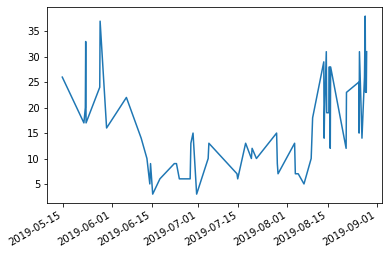

In [143]:
dataset[dataset['rain_precip_mm'] > 1]['timestamp_orig_weather'].value_counts(
).plot()


In [138]:
%matplotlib inline